In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cm
#matplotlib.rcParams.update({'font.size': 20})
mpl.rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'figure.figsize': (3,2)})
import pandas as pd
import seaborn as sns
from copy import deepcopy

import sys
import os
import subprocess
import glob
from collections import defaultdict
import scipy as sp
from scipy import special
from itertools import product

In [72]:
temp = 0.001
beta = 1/temp

data_files = glob.glob(f"/media/ian/Data/final_md_lv/variants_*t-{temp}*")

In [73]:
pot_scales = [4, 16, 64, 256, 1024]

In [74]:
# pull h5 data from files
MSD_f = np.zeros(10)
MSD_pred_f = np.zeros(10)
Ibs = []

var_idx = 0

M = 0

for data_file in data_files[:]:
    print(data_file)
    N = 0
    MSD = np.zeros(10)
    MSD_pred = np.zeros(10)
    M += 1
    with h5py.File(data_file, "r") as f:
        group = f.get("realizations")
        init_x = f.get("meta").get("init_x")[:]
        keys = group.keys()
        # print(group.get("0").get("Ib")[:])
        sum_Ib = np.zeros_like(group.get("0").get("Ib")[:,0])
        max_Ib = -group.get("0").get("Ib")[:,var_idx]*beta
        for k in keys:
            dataset = group.get(k)
            Ib = -dataset.get("Ib")[:,var_idx]*beta
            Ibs.append(Ib)
            max_Ib = np.max(np.stack([max_Ib, Ib]), axis=0)
        for k in keys:
            dataset = group.get(k)
            Ib = np.exp(-dataset.get("Ib")[:,var_idx]*beta - max_Ib)
            sum_Ib += Ib
            dataset = group.get(k)
            pos = dataset.get("pos")[:]
            msd = (1/pos.shape[1])*np.sum(np.square(pos - init_x), axis=(1,2))
            MSD += msd
            MSD_pred += msd*Ib
            N += 1
    
    MSD /= N

    MSD_pred = np.log(MSD_pred)
    MSD_pred -= np.log(sum_Ib)
    MSD_pred = np.exp(MSD_pred)

    MSD_f += MSD
    MSD_pred_f += MSD_pred

MSD_f /= M
MSD_pred_f /= M


/media/ian/Data/final_md_lv/variants_n-10_l-3.5_t-0.001_time-10_dt-1e-3_visc-5_seed-33_phi-0.9489_rA-0.5000_rB-0.7000_vs-1.h5
/media/ian/Data/final_md_lv/variants_n-10_l-3.5_t-0.001_time-10_dt-1e-3_visc-5_seed-36_phi-0.9489_rA-0.5000_rB-0.7000_vs-1.h5
/media/ian/Data/final_md_lv/variants_n-10_l-3.5_t-0.001_time-10_dt-1e-3_visc-5_seed-30_phi-0.9489_rA-0.5000_rB-0.7000_vs-1.h5
/media/ian/Data/final_md_lv/variants_n-10_l-3.5_t-0.001_time-10_dt-1e-3_visc-5_seed-34_phi-0.9489_rA-0.5000_rB-0.7000_vs-1.h5
/media/ian/Data/final_md_lv/variants_n-10_l-3.5_t-0.001_time-10_dt-1e-3_visc-5_seed-38_phi-0.9489_rA-0.5000_rB-0.7000_vs-1.h5
/media/ian/Data/final_md_lv/variants_n-10_l-3.5_t-0.001_time-10_dt-1e-3_visc-5_seed-32_phi-0.9489_rA-0.5000_rB-0.7000_vs-1.h5
/media/ian/Data/final_md_lv/variants_n-10_l-3.5_t-0.001_time-10_dt-1e-3_visc-5_seed-31_phi-0.9489_rA-0.5000_rB-0.7000_vs-1.h5
/media/ian/Data/final_md_lv/variants_n-10_l-3.5_t-0.001_time-10_dt-1e-3_visc-5_seed-37_phi-0.9489_rA-0.5000_rB-0.7000_

In [57]:
time = np.linspace(1, 10, 10)

Text(0.5, 1.0, 'vscale=4.0, TEMP=0.001')

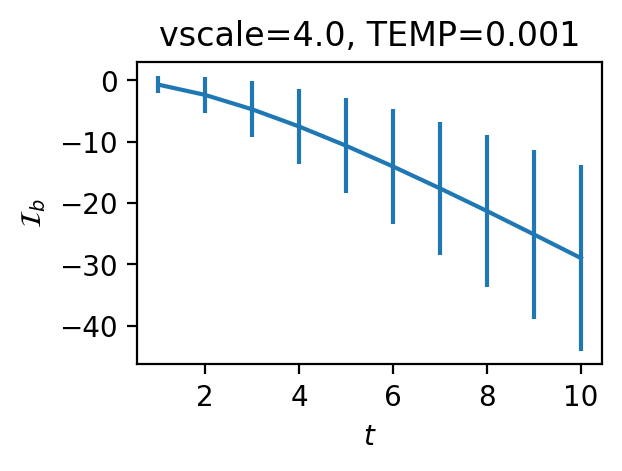

In [75]:
plt.errorbar(x=time, y=np.mean(Ibs, axis=0), yerr=np.std(Ibs, axis=0))
plt.ylabel(r"$\mathcal{I}_b$")
plt.xlabel(r"$t$")
plt.title(f"vscale={pot_scales[var_idx]:.1f}, TEMP={temp}")

In [64]:
print(len(Ibs))

100000


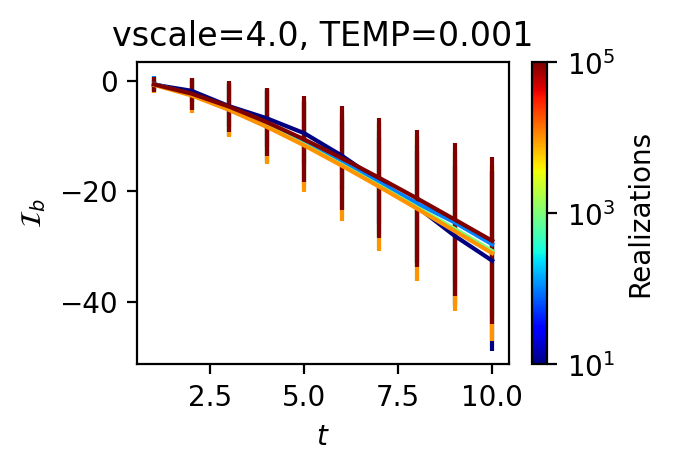

In [76]:
norm = colors.LogNorm(vmin=10, vmax=len(Ibs))
cmap = cm.jet

for i in [10, 100, 1000, 10000, len(Ibs)]:
    plt.errorbar(x=time, y=np.mean(Ibs[:i], axis=0), yerr=np.std(Ibs[:i], axis=0), color=cmap(norm(i)))
plt.ylabel(r"$\mathcal{I}_b$")
plt.xlabel(r"$t$")
plt.title(f"vscale={pot_scales[var_idx]:.1f}, TEMP={temp}")
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(sm, label="Realizations")

In [29]:
def fetch_xyz(file, dim=2, stride=1):
    assert(dim==2 or dim==3)
    output = []
    idx = 0
    with open(file, "r") as xyz:
        try:
            while True:
                N = int(xyz.readline())
                xyz.readline()
                arr = np.empty((N, dim))
                for i in np.arange(N):
                    line = xyz.readline()
                    _, x, y, z, _ = line.split()
                    if dim == 2:
                        arr[i] = np.array([float(x), float(y)])
                    else:
                        arr[i] = np.array([float(x), float(y), float(z)])
                if idx % stride == 0:
                    output.append(arr)
        except:
            pass
    return np.array(output)

def parse_tag(string, tag):
    return ".".join(string.split(".")[:-1]).split(f"_{tag}-")[1].split("_")[0]

In [77]:
data_files_val = glob.glob(f"/media/ian/Data/final_md_lv_validation/traj_*t-{temp}*")
data_dict_val = {}
for d in data_files_val:
    val = parse_tag(d, "vs")
    if parse_tag(d, "vs") in data_dict_val:
        data_dict_val[val].append(d)
    else:
        data_dict_val[val] = []
        data_dict_val[val].append(d)

In [78]:
MSD_val = {}
for k, v in data_dict_val.items():
    print(k)
    msd = np.zeros(10)
    N = 0
    for f in v:
        pos = fetch_xyz(f)
        msd += (1/pos.shape[1])*np.sum(np.square(pos[1:] - pos[0]), axis=(1,2))
        N += 1
    msd /= N
    MSD_val[k] = msd

64
1
8
256
16
2
1024
4


Text(0.5, 1.0, 'vscale=4.0, TEMP=0.001')

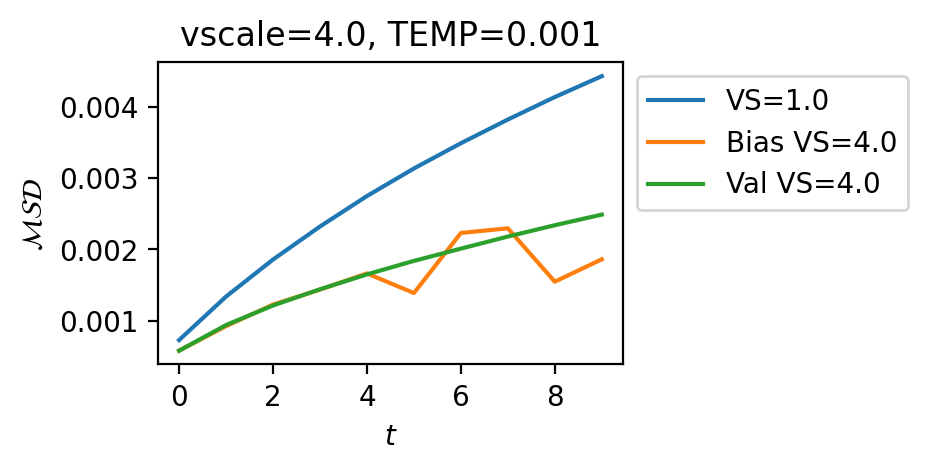

In [79]:
# plot prediction
plt.plot(MSD, label="VS=1.0")
plt.plot(MSD_pred, label=f"Bias VS={pot_scales[var_idx]:.1f}")
plt.plot(MSD_val[str(pot_scales[var_idx])], label=f"Val VS={pot_scales[var_idx]:.1f}")
plt.ylabel(r"$\mathcal{MSD}$")
plt.xlabel(r"$t$")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.title(f"vscale={pot_scales[var_idx]:.1f}, TEMP={temp}")